In [18]:
import time
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
from requests.exceptions import RequestException, Timeout
from typing import Optional

BASE_URL = "http://www.bmatraffic.com"

## 1. GISTDA Backend get `session ID` from `www.bmatraffic.com`

In [87]:
def get_session_id(url: str):
    try:
        response = requests.get(url, timeout=60)  # Timeout set to 60 seconds
        response.raise_for_status()
        cookie = response.headers.get('Set-Cookie', '')
        if cookie:
            session_id = cookie.split("=")[1].split(";")[0]
            return session_id
        return None
    except Timeout:
        print("Error: Request timed out while getting session ID")
        return None
    except RequestException as e:
        print(f"Error getting session ID: {e}")
        return None

### We will need 1 session ID for each CCTV. For example, let's say there are 2 CCTV, so we need 2 session ID for each CCTV

In [88]:
session_id_1 = get_session_id(BASE_URL)
session_id_2 = get_session_id(BASE_URL)

print(f"Session ID 1: {session_id_1}")
print(f"Session ID 2: {session_id_2}")

Session ID 1: gjep15w3nu5rdwolnfujcp0j
Session ID 2: ivv3rygahyrrjipb5ktjeh2n


## 2. Next, we will ask `www.bmatraffic.com` to stream image from each CCTV to each `session ID` we have

In [89]:
def play_video(camera_id: int, session_id: str):
    url = f"{BASE_URL}/PlayVideo.aspx?ID={camera_id}"
    headers = {
        'Referer': f'{BASE_URL}/index.aspx',
        'Cookie': f'ASP.NET_SessionId={session_id};',
        'Priority': 'u=4'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        time.sleep(1)  # Give some time for the video to start streaming
        return #get_image(camera_id, session_id, save_path, save_to_db, img_size)
    except RequestException as e:
        print(f"Error playing video: {e}")
        return False
    
play_video(7, session_id_1)
play_video(11, session_id_2)

## 3. Now, `www.bmatraffic.com` is streaming CCTV image to each `session ID` we have

### Let's see if we can view the image from CCTV or not

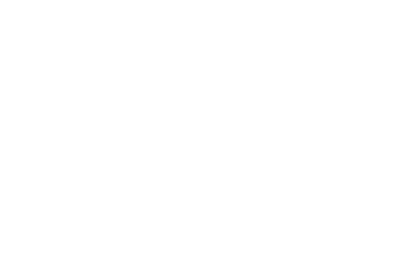

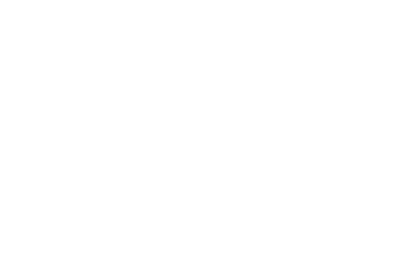

In [91]:
def get_image(session_id: str) -> bool:
    url = f"{BASE_URL}/show.aspx"
    headers = {
        'Cookie': f'ASP.NET_SessionId={session_id};',
        'Priority': 'u=4'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        display(img)

    except RequestException as e:
        print(f"Error getting image: {e}")
        return False

# play_video(7, session_id_1)
# play_video(11, session_id_2)
# 30 minutes?


get_image(session_id_1)
get_image(session_id_2)

## Ok, so how can we do all of this from GISTDA Backend?

### First approach, we just give them specific `session ID` for each camera they want to see and let them connect to `www.bmatraffic.com/show.aspx` on their device

User 1 viewing CCTV 7


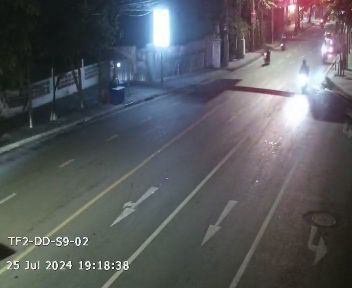

User 2 viewing CCTV 11


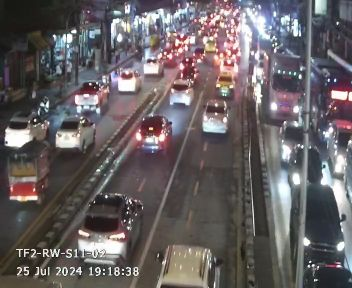

User 3 viewing CCTV 7


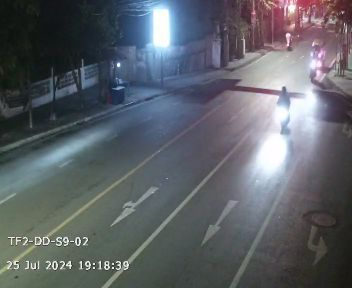

User 4 viewing CCTV 11


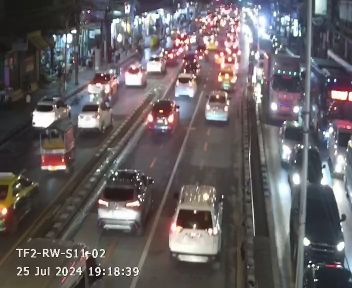

User 5 viewing CCTV 7


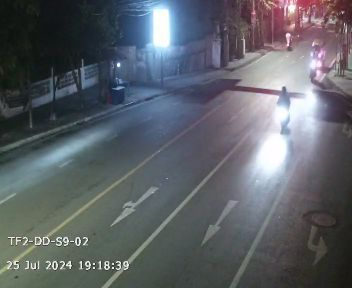

User 6 viewing CCTV 11


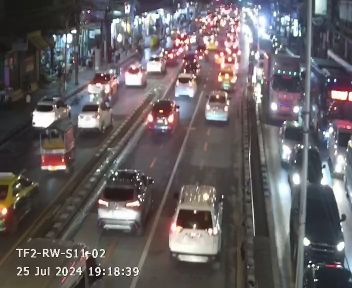

User 7 viewing CCTV 7


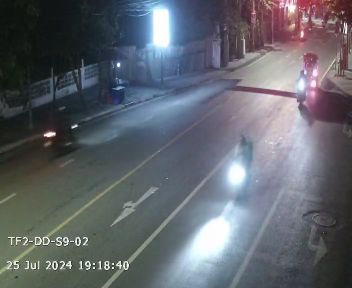

User 8 viewing CCTV 11


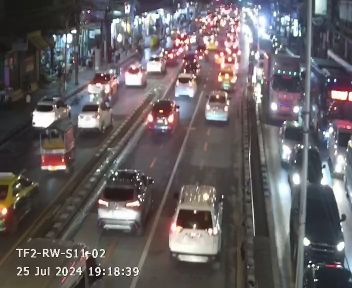

In [23]:
print(f"User 1 viewing CCTV 7")
get_image(session_id_1)
print(f"User 2 viewing CCTV 11")
get_image(session_id_2)

print(f"User 3 viewing CCTV 7")
get_image(session_id_1)
print(f"User 4 viewing CCTV 11")
get_image(session_id_2)

print(f"User 5 viewing CCTV 7")
get_image(session_id_1)
print(f"User 6 viewing CCTV 11")
get_image(session_id_2)

### Second approach, we act as a middle man. GISTDA Backend fetches images continuously from `www.bmatraffic.com` and then distributes these images to connected clients.

#### 1. Fetch Images from the Source
GISTDA backend will act as a client to `www.bmatraffic.com`, fetching images periodically by sending HTTP requests to fetch new images for every 5 minutes.

#### 2. Broadcast to Connected Clients
Use WebSocket for Real-time images broadcasting to multiple clients. WebSockets allow real-time, bidirectional communication between the server and clients, making them suitable for streaming data like images.

#### 3. Implementation Steps
**3.1 Backend Implementation**

Use frameworks like SocketIO, Flask-SocketIO, Django Channels, or FastAPI with WebSockets.
When a client connects, add it to a list of active connections.

**3.2 Image Fetching and Broadcasting**

In a loop, fetch images from http://www.bmatraffic.com/show.aspx using the session ID and camera ID.
Once an image is fetched, broadcast it to all connected clients using the WebSocket connections.

**3.3 Client Implementation**

Clients connect to GISTDA backend's WebSocket endpoint to receive the image stream.
Display the images in real-time as they are received from the WebSocket connection.